# Image Generation Using Diffusion Models

This notebook has been partly adapted from this excellent diffusion model [tutorial](https://huggingface.co/blog/annotated-diffusion) by Rogge & Rasul and follows the [paper](https://arxiv.org/abs/2006.11239) by He et al.

While GANs can produce very high quality results, they are notorious for unstable training.

Here we will explore a new type of generative models commonly known as diffusion models. Diffusion models generate image by gradually refining Gaussian Noise and making it more and more into real image at each timestep.
Diffusion Models consist of two process; Forward Diffusion Process and Reverse Denoising Process.
In forward diffusion process, we gradually add noise to a real image till it just looks like Gaussian Noise. This process is fixed. We do not learn it.
In reverse denosing process, we add denoise a Gaussian noise gradually till it looks like a real image. This process is generative and we learn this.

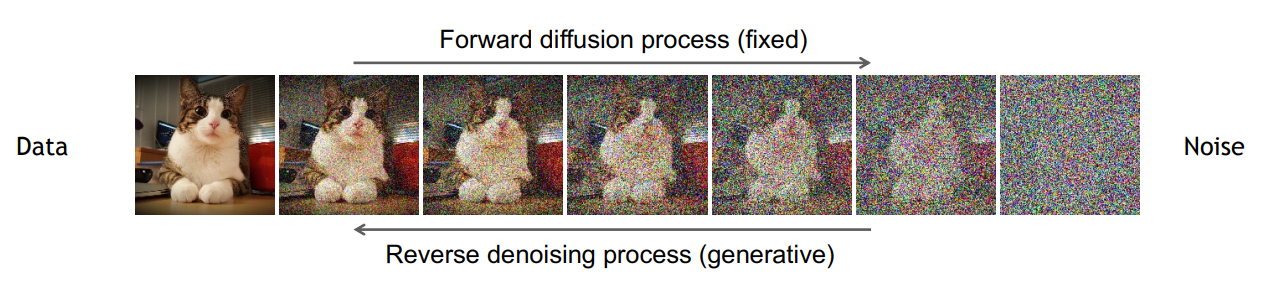

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import Compose, ToTensor, Lambda
from torchsummary import summary
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from tqdm import tqdm
import numpy as np

In [2]:
EPOCHS = 100
LEARNING_RATE = 1e-3
BATCH_SIZE = 128
TIME_EMBEDDING_DIM = 100
TIMESTAMPS = 300

In [3]:
transform_steps = Compose([
            ToTensor(),
            Lambda(lambda t: (t * 2) - 1)
])

In [4]:
# We will be using the mnist digit data.
mnist_dataset = datasets.MNIST(root="minist_data/", download=True, transform=transform_steps)

/opt/anaconda3/envs/mlcourse/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1616554799287/work/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
# Initializing pytorch dataloader
train_dataloader = DataLoader(mnist_dataset, batch_size=BATCH_SIZE, shuffle=True)

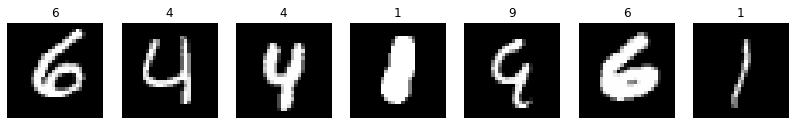

In [6]:
# Visualizing some sample images
figure = plt.figure(figsize=(14, 14))
cols, rows = 7, 1
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(mnist_dataset), size=(1,)).item()
    img, label = mnist_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'


## What is a diffusion model?

A (denoising) diffusion model isn't that complex if you compare it to other generative models such as Normalizing Flows, GANs or VAEs: they all convert noise from some simple distribution to a data sample. This is also the case here where **a neural network learns to gradually denoise data** starting from pure noise. 

In a bit more detail for images, the set-up consists of 2 processes:
* a fixed (or predefined) forward diffusion process $q$ of our choosing, that gradually adds Gaussian noise to an image, until you end up with pure noise
* a learned reverse denoising diffusion process $p_\theta$, where a neural network is trained to gradually denoise an image starting from pure noise, until you end up with an actual image.

<p align="center">
    <img src="https://drive.google.com/uc?id=1t5dUyJwgy2ZpDAqHXw7GhUAp2FE5BWHA" width="600" />
</p>

Both the forward and reverse process indexed by \\(t\\) happen for some number of finite time steps \\(T\\) (the DDPM authors use \\(T=1000\\)). You start with \\(t=0\\) where you sample a real image \\(\mathbf{x}_0\\) from your data distribution (let's say an image of a cat from ImageNet), and the forward process samples some noise from a Gaussian distribution at each time step \\(t\\), which is added to the image of the previous time step. Given a sufficiently large \\(T\\) and a well behaved schedule for adding noise at each time step, you end up with what is called an [isotropic Gaussian distribution](https://math.stackexchange.com/questions/1991961/gaussian-distribution-is-isotropic) at \\(t=T\\) via a gradual process.

## In more mathematical form

Let's write this down more formally, as ultimately we need a tractable loss function which our neural network needs to optimize. 

Let \\(q(\mathbf{x}_0)\\) be the real data distribution, say of "real images". We can sample from this distribution to get an image, \\(\mathbf{x}_0 \sim q(\mathbf{x}_0)\\). We define the forward diffusion process \\(q(\mathbf{x}_t | \mathbf{x}_{t-1})\\) which adds Gaussian noise at each time step \\(t\\), according to a known variance schedule \\(0 < \beta_1 < \beta_2 < ... < \beta_T < 1\\) as
$$
q(\mathbf{x}_t | \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \mathbf{x}_{t-1}, \beta_t \mathbf{I}). 
$$

Recall that a normal distribution (also called Gaussian distribution) is defined by 2 parameters: a mean \\(\mu\\) and a variance \\(\sigma^2 \geq 0\\). Basically, each new (slightly noiser) image at time step \\(t\\) is drawn from a **conditional Gaussian distribution** with \\(\mathbf{\mu}_t = \sqrt{1 - \beta_t} \mathbf{x}_{t-1}\\) and \\(\sigma^2_t = \beta_t\\), which we can do by sampling \\(\mathbf{\epsilon} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})\\) and then setting \\(\mathbf{x}_t = \sqrt{1 - \beta_t} \mathbf{x}_{t-1} +  \sqrt{\beta_t} \mathbf{\epsilon}\\). 

Note that the \\(\beta_t\\) aren't constant at each time step \\(t\\) (hence the subscript) --- in fact one defines a so-called **"variance schedule"**, which can be linear, quadratic, cosine, etc. as we will see further (a bit like a learning rate schedule). 

So starting from \\(\mathbf{x}_0\\), we end up with \\(\mathbf{x}_1,  ..., \mathbf{x}_t, ..., \mathbf{x}_T\\), where \\(\mathbf{x}_T\\) is pure Gaussian noise if we set the schedule appropriately.

Now, if we knew the conditional distribution \\(p(\mathbf{x}_{t-1} | \mathbf{x}_t)\\), then we could run the process in reverse: by sampling some random Gaussian noise \\(\mathbf{x}_T\\), and then gradually "denoise" it so that we end up with a sample from the real distribution \\(\mathbf{x}_0\\).

However, we don't know \\(p(\mathbf{x}_{t-1} | \mathbf{x}_t)\\). It's intractable since it requires knowing the distribution of all possible images in order to calculate this conditional probability. Hence, we're going to leverage a neural network to **approximate (learn) this conditional probability distribution**, let's call it \\(p_\theta (\mathbf{x}_{t-1} | \mathbf{x}_t)\\), with \\(\theta\\) being the parameters of the neural network, updated by gradient descent. 

Ok, so we need a neural network to represent a (conditional) probability distribution of the backward process. If we assume this reverse process is Gaussian as well, then recall that any Gaussian distribution is defined by 2 parameters:
* a mean parametrized by \\(\mu_\theta\\);
* a variance parametrized by \\(\Sigma_\theta\\);

so we can parametrize the process as 
$$ p_\theta (\mathbf{x}_{t-1} | \mathbf{x}_t) = \mathcal{N}(\mathbf{x}_{t-1}; \mu_\theta(\mathbf{x}_{t},t), \Sigma_\theta (\mathbf{x}_{t},t))$$
where the mean and variance are also conditioned on the noise level \\(t\\).

Hence, our neural network needs to learn/represent the mean and variance. However, the DDPM authors decided to **keep the variance fixed, and let the neural network only learn (represent) the mean \\(\mu_\theta\\) of this conditional probability distribution**. From the paper:

> First, we set \\(\Sigma_\theta ( \mathbf{x}_t, t) = \sigma^2_t \mathbf{I}\\) to untrained time dependent constants. Experimentally, both \\(\sigma^2_t = \beta_t\\) and \\(\sigma^2_t  = \tilde{\beta}_t\\) (see paper) had similar results. 

This was then later improved in the [Improved diffusion models](https://openreview.net/pdf?id=-NEXDKk8gZ) paper, where a neural network also learns the variance of this backwards process, besides the mean.

So we continue, assuming that our neural network only needs to learn/represent the mean of this conditional probability distribution.

## Defining an objective function (by reparametrizing the mean)

To derive an objective function to learn the mean of the backward process, the authors observe that the combination of \\(q\\) and \\(p_\theta\\) can be seen as a variational auto-encoder (VAE) [(Kingma et al., 2013)](https://arxiv.org/abs/1312.6114). Hence, the **variational lower bound** (also called ELBO) can be used to minimize the negative log-likelihood with respect to ground truth data sample \\(\mathbf{x}_0\\) (we refer to the VAE paper for details regarding ELBO). It turns out that the ELBO for this process is a sum of losses at each time step \\(t\\), \\(L = L_0 + L_1 + ... + L_T\\). By construction of the forward \\(q\\) process and backward process, each term (except for \\(L_0\\)) of the loss is actually the **KL divergence between 2 Gaussian distributions** which can be written explicitly as an L2-loss with respect to the means!

A direct consequence of the constructed forward process \\(q\\), as shown by Sohl-Dickstein et al., is that we can sample \\(\mathbf{x}_t\\) at any arbitrary noise level conditioned on \\(\mathbf{x}_0\\) (since sums of Gaussians is also Gaussian). This is very convenient:  we don't need to apply \\(q\\) repeatedly in order to sample \\(\mathbf{x}_t\\). 
We have that 
$$q(\mathbf{x}_t | \mathbf{x}_0) = \cal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, (1- \bar{\alpha}_t) \mathbf{I})$$

with \\(\alpha_t := 1 - \beta_t\\) and \\(\bar{\alpha}t := \Pi_{s=1}^{t} \alpha_s\\). Let's refer to this equation as the "nice property". This means we can sample Gaussian noise and scale it appropriatly and add it to \\(\mathbf{x}_0\\) to get \\(\mathbf{x}_t\\) directly. Note that the \\(\bar{\alpha}_t\\) are functions of the known \\(\beta_t\\) variance schedule and thus are also known and can be precomputed. This then allows us, during training, to **optimize random terms of the loss function \\(L\\)** (or in other words, to randomly sample \\(t\\) during training and optimize \\(L_t\\).

Another beauty of this property, as shown in Ho et al. is that one can (after some math, for which we refer the reader to [this excellent blog post](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/)) instead **reparametrize the mean to make the neural network learn (predict) the added noise (via a network \\(\mathbf{\epsilon}_\theta(\mathbf{x}_t, t)\\) for noise level \\(t\\)** in the KL terms which constitute the losses. This means that our neural network becomes a noise predictor, rather than a (direct) mean predictor. The mean can be computed as follows:

$$ \mathbf{\mu}_\theta(\mathbf{x}_t, t) = \frac{1}{\sqrt{\alpha_t}} \left(  \mathbf{x}_t - \frac{\beta_t}{\sqrt{1- \bar{\alpha}_t}} \mathbf{\epsilon}_\theta(\mathbf{x}_t, t) \right)$$

The final objective function \\(L_t\\) then looks as follows (for a random time step \\(t\\) given \\(\mathbf{\epsilon} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})\\) ): 

$$ \| \mathbf{\epsilon} - \mathbf{\epsilon}_\theta(\mathbf{x}_t, t) \|^2 = \| \mathbf{\epsilon} - \mathbf{\epsilon}_\theta( \sqrt{\bar{\alpha}_t} \mathbf{x}_0 + \sqrt{(1- \bar{\alpha}_t)  } \mathbf{\epsilon}, t) \|^2.$$

Here, \\(\mathbf{x}_0\\) is the initial (real, uncorruped) image, and we see the direct noise level \\(t\\) sample given by the fixed forward process. \\(\mathbf{\epsilon}\\) is the pure noise sampled at time step \\(t\\), and \\(\mathbf{\epsilon}_\theta (\mathbf{x}_t, t)\\) is our neural network. The neural network is optimized using a simple mean squared error (MSE) between the true and the predicted Gaussian noise.

The training algorithm now looks as follows:


<p align="center">
    <img src="https://drive.google.com/uc?id=1LJsdkZ3i1J32lmi9ONMqKFg5LMtpSfT4" width="400" />
</p>

In other words:
* we take a random sample $\mathbf{x}_0$ from the real unknown and possibily complex data distribution $q(\mathbf{x}_0)$
* we sample a noise level $t$ uniformally between $1$ and $T$ (i.e., a random time step)
* we sample some noise from a Gaussian distribution and corrupt the input by this noise at level $t$ using the nice property defined above
* the neural network is trained to predict this noise based on the corruped image $\mathbf{x}_t$, i.e. noise applied on $\mathbf{x}_0$ based on known schedule $\beta_t$

In reality, all of this is done on batches of data as one uses stochastic gradient descent to optimize neural networks.

## The neural network

The neural network needs to take in a noised image at a particular time step and return the predicted noise. Note that the predicted noise is a tensor that has the same size/resolution as the input image. So technically, the network takes in and outputs tensors of the same shape. What type of neural network can we use for this? 

What is typically used here is very similar to that of an [Autoencoder](https://en.wikipedia.org/wiki/Autoencoder), which you may remember from typical "intro to deep learning" tutorials. Autoencoders have a so-called "bottleneck" layer in between the encoder and decoder. The encoder first encodes an image into a smaller hidden representation called the "bottleneck", and the decoder then decodes that hidden representation back into an actual image. This forces the network to only keep the most important information in the bottleneck layer.

In terms of architecture, the DDPM authors went for a **U-Net**, introduced by ([Ronneberger et al., 2015](https://arxiv.org/abs/1505.04597)) (which, at the time, achieved state-of-the-art results for medical image segmentation). This network, like any autoencoder, consists of a bottleneck in the middle that makes sure the network learns only the most important information. Importantly, it introduced residual connections between the encoder and decoder, greatly improving gradient flow (inspired by ResNet in [He et al., 2015](https://arxiv.org/abs/1512.03385)).

<p align="center">
    <img src="https://drive.google.com/uc?id=1_Hej_VTgdUWGsxxIuyZACCGjpbCGIUi6" width="400" />
</p>

As can be seen, a U-Net model first downsamples the input (i.e. makes the input smaller in terms of spatial resolution), after which upsampling is performed.

Below, we implement a simple u-net of our own design, step-by-step.

### Position embeddings

As the parameters of the neural network are shared across time (noise level), the authors employ sinusoidal position embeddings to encode $t$, inspired by the Transformer ([Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)). This makes the neural network "know" at which particular time step (noise level) it is operating, for every image in a batch.

The `SinusoidalPositionEmbeddings` module takes a tensor of shape `(batch_size, 1)` as input (i.e. the noise levels of several noisy images in a batch), and turns this into a tensor of shape `(batch_size, dim)`, with `dim` being the dimensionality of the position embeddings. This is then added to each residual block, as we will see further.

In [8]:
# We define some basic model blocks here which we will utilize later in our model.
class ConvBlock(nn.Module):
    """Convolution Block."""
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, time_emb_dim, last=False):
        super(ConvBlock, self).__init__()
        self.last = last
        self.time_mlp = nn.Linear(time_emb_dim, in_channels)
        self.conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        if not self.last:
            self.batch_norm_layer = nn.BatchNorm2d(out_channels)
            self.act = nn.LeakyReLU()

    def forward(self, x, t):
        t = self.time_mlp(t)
        x = x + t.view(*t.shape, 1, 1)
        x = self.conv_layer(x)
        if not self.last:
            x = self.batch_norm_layer(x)
            x = self.act(x)
        return x


class UpSampleBlock(nn.Module):
    """Up Sampling Block."""
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, output_padding, time_emb_dim, last=False):
        super(UpSampleBlock, self).__init__()
        self.last = last
        self.time_mlp = nn.Linear(time_emb_dim, in_channels)
        self.conv_trans_layer = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, output_padding=output_padding)
        if not self.last:
            self.batch_norm_layer = nn.BatchNorm2d(out_channels)
            self.act = nn.LeakyReLU()

    def forward(self, x, t):
        t = self.time_mlp(t)
        x = x + t.view(*t.shape, 1, 1)
        x = self.conv_trans_layer(x)
        if not self.last:
            x = self.batch_norm_layer(x)
            x = self.act(x)
        return x


class LinearBlock(nn.Module):
    """Linear Block."""
    def __init__(self, in_dim, out_dim, time_emb_dim):
        super(LinearBlock, self).__init__()
        self.time_mlp = nn.Linear(time_emb_dim, in_dim)
        self.linear_layer = nn.Linear(in_dim, out_dim)
        self.batch_norm_layer = nn.BatchNorm1d(out_dim)
        self.act = nn.LeakyReLU()

    def forward(self, x, t):
        t = self.time_mlp(t)
        x = x + t
        x = self.linear_layer(x)
        x = self.batch_norm_layer(x)
        x = self.act(x)
        return x


class SinusoidalPositionEmbeddings(nn.Module):
    """Encode timestep to dim dimensional vector"""
    def __init__(self, dim):
        super(SinusoidalPositionEmbeddings, self).__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = np.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)

        return embeddings


In [9]:
class Reshape(nn.Module):
  """A custom reshape layer."""
  def __init__(self, shape):
    super(Reshape, self).__init__()
    self.shape = shape

  def forward(self, x):
    return x.view(*self.shape)


class DiffusionModel(nn.Module):
  """Diffusion model"""
  def __init__(self, time_emb_dim):
    super(DiffusionModel, self).__init__()
    self.time_emb_dim = time_emb_dim

    self.time_embedding_model = nn.Sequential(
        SinusoidalPositionEmbeddings(200),
        nn.Linear(200, time_emb_dim),
        nn.LeakyReLU(),
        nn.Linear(time_emb_dim, time_emb_dim)
    )
    
    self.dsb_1 = ConvBlock(in_channels=1, out_channels=64, kernel_size=5, stride=2, padding=2, time_emb_dim=time_emb_dim)
    self.conv1 = ConvBlock(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1, time_emb_dim=time_emb_dim)
    self.dsb_2 = ConvBlock(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1, time_emb_dim=time_emb_dim)
    self.conv2 = ConvBlock(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, time_emb_dim=time_emb_dim)
    self.dsb_3 = ConvBlock(in_channels=256, out_channels=512, kernel_size=3, stride=2, padding=1, time_emb_dim=time_emb_dim)

    self.flatten = nn.Flatten(1,-1)

    self.linear_1 = LinearBlock(in_dim=512*4*4, out_dim=256, time_emb_dim=time_emb_dim)
    self.linear_2 = LinearBlock(in_dim=256, out_dim=128, time_emb_dim=time_emb_dim)

    self.linear_3 = LinearBlock(in_dim=128, out_dim=256, time_emb_dim=time_emb_dim)
    self.linear_4 = LinearBlock(in_dim=256, out_dim=512*4*4, time_emb_dim=time_emb_dim)

    self.reshape = Reshape((-1,512,4,4))

    self.usb_1 = UpSampleBlock(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=0, time_emb_dim=time_emb_dim)
    self.conv3 = ConvBlock(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, time_emb_dim=time_emb_dim)
    self.usb_2 = UpSampleBlock(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1, time_emb_dim=time_emb_dim)
    self.conv4 = ConvBlock(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1, time_emb_dim=time_emb_dim)
    self.usb_3 = UpSampleBlock(in_channels=64, out_channels=32, kernel_size=5, stride=2, padding=2, output_padding=1, time_emb_dim=time_emb_dim)
    self.conv5 = ConvBlock(in_channels=32, out_channels=1, kernel_size=1, stride=1, padding=0, time_emb_dim=time_emb_dim, last=True)


  def forward(self, x, t):
    t = self.time_embedding_model(t)
    x1 = self.dsb_1(x, t)
    x2 = self.conv1(x1, t)
    x3 = self.dsb_2(x2, t)
    x4 = self.conv2(x3, t)
    x5 = self.dsb_3(x4, t)

    x5_ = self.flatten(x5)
    x6 = self.linear_1(x5_, t)
    x7 = self.linear_2(x6, t)
    x = self.linear_3(x7, t)
    x = self.linear_4(x+x6, t)
    x = self.reshape(x)

    x = self.usb_1(x+x5, t)
    x = self.conv3(x+x4, t)
    x = self.usb_2(x+x3, t)
    x = self.conv4(x+x2, t)
    x = self.usb_3(x+x1, t)
    x = self.conv5(x, t)

    return x


model = DiffusionModel(time_emb_dim=TIME_EMBEDDING_DIM)
model.to(device)

DiffusionModel(
  (time_embedding_model): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=200, out_features=100, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=100, out_features=100, bias=True)
  )
  (dsb_1): ConvBlock(
    (time_mlp): Linear(in_features=100, out_features=1, bias=True)
    (conv_layer): Conv2d(1, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (batch_norm_layer): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): LeakyReLU(negative_slope=0.01)
  )
  (conv1): ConvBlock(
    (time_mlp): Linear(in_features=100, out_features=64, bias=True)
    (conv_layer): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batch_norm_layer): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): LeakyReLU(negative_slope=0.01)
  )
  (dsb_2): ConvBlock(
    (time_mlp): Linear(in_features=100, out_features=128, bias=True)

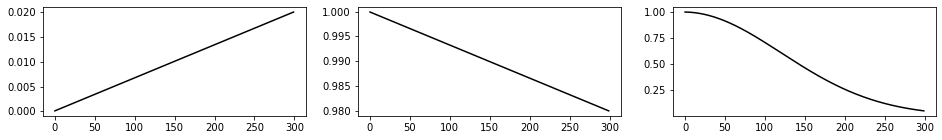

In [10]:
def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

# define beta schedule
betas = linear_beta_schedule(timesteps=TIMESTAMPS)

# define alphas 
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = nn.functional.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

fig, axs = plt.subplots(1, 3, figsize=(16, 2))
axs[0].plot(betas, 'k')
axs[1].plot(alphas, 'k')
axs[2].plot(alphas_cumprod, 'k')

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [11]:
# forward diffusion
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise


In [12]:
def p_losses(denoise_model, x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
    predicted_noise = denoise_model(x_noisy, t)

    loss = nn.functional.smooth_l1_loss(noise, predicted_noise)

    return loss


In [13]:
# Defining the optimizer here
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [14]:
# Training loop
for i in range(1,EPOCHS+1):
  running_loss = 0
  pbar = tqdm(train_dataloader)
  for b, data in enumerate(pbar):
    # Every data instance is an input + label pair. We don't need the label
    inputs, _ = data
    inputs = inputs.to(device)

    # Zero the gradients for every batch!
    optimizer.zero_grad()

    t = torch.randint(0, TIMESTAMPS, (inputs.shape[0],), device=device).long()

    # Compute the loss and its gradients
    loss = p_losses(model, inputs, t)
    loss.backward()

    # Adjust learning weights
    optimizer.step()
    
    # Update Progress
    running_loss += loss.item()
    pbar.set_description(f"Epoch {i}/{EPOCHS}: ")
    pbar.set_postfix({"batch_loss": loss.item(), "avg_loss": running_loss/(b+1)})


Epoch 1/100: :   4%| | 21/469 [01:26<30:37,  4.10s/it, batch_loss=0.112, avg_los


KeyboardInterrupt: 

## Sampling

As we'll sample from the model during training (in order to track progress), we define the code for that below. Sampling is summarized in the paper as Algorithm 2:

<img src="https://drive.google.com/uc?id=1ij80f8TNBDzpKtqHjk_sh8o5aby3lmD7" width="500" />

Generating new images from a diffusion model happens by reversing the diffusion process: we start from $T$, where we sample pure noise from a Gaussian distribution, and then use our neural network to gradually denoise it (using the conditional probability it has learned), until we end up at time step $t = 0$. As shown above, we can derive a slighly less denoised image $\mathbf{x}_{t-1 }$ by plugging in the reparametrization of the mean, using our noise predictor. Remember that the variance is known ahead of time.

Ideally, we end up with an image that looks like it came from the real data distribution.

The code below implements this.

In [ ]:
@torch.no_grad()
def p_sample(model, x, t, t_index):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)
    
    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

# Algorithm 2 (including returning all images)
@torch.no_grad()
def p_sample_loop(model, shape):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []

    for i in tqdm(reversed(range(0, TIMESTAMPS)), desc='sampling loop time step', total=TIMESTAMPS):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3):
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))


In [ ]:
# sample 64 images
samples = sample(model, image_size=28, batch_size=64, channels=1)

# show a random one
random_index = 5
plt.imshow(samples[-1][random_index].reshape(28, 28), cmap="gray")


In [ ]:
import matplotlib.animation as animation
from matplotlib import rc
random_index = 53

fig = plt.figure()
ims = []
for i in range(TIMESTAMPS):
    im = plt.imshow(samples[i][random_index].reshape(28, 28), cmap="gray", animated=True)
    ims.append([im])
    # plt.show()

animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
rc('animation', html='jshtml')
# animate.save('diffusion.gif')
# plt.show()
animate
